In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 
  
# metadata 
print(covertype.metadata) 
  
# variable information 
print(covertype.variables) 


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 5. 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("\n标准化后的数据（前5行）：")
print(X[:5])

# 6. 数据集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 检查并转换 y_train 和 y_test 的数据类型
y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

# 7. 转换为 PyTorch 的 tensor 格式，并创建 DataLoader
batch_size = 256
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 定义神经网络
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # 构建网络层
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))  # 第一个隐藏层的 Dropout

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))  # 中间层的 Dropout

        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # 输出层
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# 定义超参数
input_size = X_train_tensor.shape[1]
hidden_layers = [128, 64]  # 隐藏层神经元数量
dropout_rate = 0.05  # Dropout 的丢弃率
learning_rate = 0.001  # 学习率
alpha = 0.001  # L2 正则化
num_epochs = 100  # 最大迭代次数
early_stop_patience = 20  # 早停的容忍次数

# 模型实例化
model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)

# 早停实现
best_val_loss = float('inf')
patience_counter = 0

# 记录训练和验证的损失与准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    # 逐批次训练
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1)  # 将 y_batch 转换为 1D

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # 累加损失和正确预测数
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()

    # 计算平均训练损失和准确率
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stop triggered! Stopping training at epoch {epoch+1}.")
            break

# 可视化训练和验证过程
plt.figure(figsize=(15, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



标准化后的数据（前5行）：
[[-1.29780509e+00 -9.35156981e-01 -1.48281978e+00 -5.37674011e-02
  -7.96272594e-01 -1.18014587e+00  3.30743212e-01  4.39143313e-01
   1.42960399e-01  3.24628306e+00  1.10807983e+00 -7.24162759e-02
  -1.14549042e-01 -9.14905313e-02 -1.47649250e-01 -5.24997930e-02
  -1.06985932e-01 -1.34443975e-02 -1.75550016e-02 -4.44752360e-02
  -2.43946810e-01 -1.47734423e-01 -2.33216171e-01 -1.75866443e-01
  -3.21251264e-02 -2.27231846e-03 -7.01478695e-02 -7.69715390e-02
  -5.72638872e-02 -8.34800147e-02 -1.27255868e-01 -3.80051874e-02
  -2.46859838e-01 -3.32219214e-01 -1.94973038e-01 -2.85741845e-02
  -6.69026389e-02 -4.32741576e-02 -4.03837703e-02  2.01033582e+00
  -2.34031401e-01 -2.14979610e-01 -3.15238030e-01 -2.90284104e-01
  -5.27300460e-02 -5.71427461e-02 -1.43128266e-02 -2.26530657e-02
  -1.65956116e-01 -1.56013984e-01 -1.23653545e-01 -2.32859052e-01
  -8.79364021e-01 -2.60672949e-01]
 [-1.31923485e+00 -8.90479669e-01 -1.61636259e+00 -2.70187909e-01
  -8.99197053e-01 -1.25710

IndexError: Target 2 is out of bounds.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('forest_cover_data.csv')  # 替换为实际文件名

# 检查数据
print("数据概览：")
print(data.head())
print("\n数据描述：")
print(data.describe())

# 分离特征和目标标签
X = data.drop(columns=['Cover_Type']).values  # 假设目标列名为 'Cover_Type'
y = data['Cover_Type'].values

# 将目标标签转换为从 0 开始的整数索引
y = y - 1  # 如果标签从 1 开始，将其转换为从 0 开始

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("\n标准化后的数据（前5行）：")
print(X[:5])

# 数据集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换为 PyTorch 的 tensor 格式，并创建 DataLoader
batch_size = 256
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义神经网络
class ForestCoverANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate, num_classes):
        super(ForestCoverANN, self).__init__()
        self.layers = nn.ModuleList()

        # 构建网络层
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))  # 第一个隐藏层的 Dropout

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))  # 中间层的 Dropout

        self.layers.append(nn.Linear(hidden_layers[-1], num_classes))  # 输出层

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 定义超参数
input_size = X_train_tensor.shape[1]
hidden_layers = [128, 64]  # 隐藏层神经元数量
dropout_rate = 0.05  # Dropout 的丢弃率
learning_rate = 0.001  # 学习率
alpha = 0.001  # L2 正则化
num_classes = len(np.unique(y))  # 分类数量
num_epochs = 100  # 最大迭代次数
early_stop_patience = 20  # 早停的容忍次数

# 模型实例化
model = ForestCoverANN(input_size, hidden_layers, dropout_rate, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)

# 早停实现
best_val_loss = float('inf')
patience_counter = 0

# 记录训练和验证的损失与准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    # 逐批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # 累加损失和正确预测数
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()

    # 计算平均训练损失和准确率
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stop triggered! Stopping training at epoch {epoch+1}.")
            break

# 可视化训练和验证过程
plt.figure(figsize=(15, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'forest_cover_data.csv'

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 使用 ucimlrepo 加载森林覆盖类型数据集
covertype = fetch_ucirepo(id=31)
X = covertype.data.features  # 特征
y = covertype.data.targets   # 目标标签


原始目标值范围: min=0, max=6
调整后目标值范围: min=0, max=6

标准化后的数据（前5行）：
[[-1.29780509e+00 -9.35156981e-01 -1.48281978e+00 -5.37674011e-02
  -7.96272594e-01 -1.18014587e+00  3.30743212e-01  4.39143313e-01
   1.42960399e-01  3.24628306e+00  1.10807983e+00 -7.24162759e-02
  -1.14549042e-01 -9.14905313e-02 -1.47649250e-01 -5.24997930e-02
  -1.06985932e-01 -1.34443975e-02 -1.75550016e-02 -4.44752360e-02
  -2.43946810e-01 -1.47734423e-01 -2.33216171e-01 -1.75866443e-01
  -3.21251264e-02 -2.27231846e-03 -7.01478695e-02 -7.69715390e-02
  -5.72638872e-02 -8.34800147e-02 -1.27255868e-01 -3.80051874e-02
  -2.46859838e-01 -3.32219214e-01 -1.94973038e-01 -2.85741845e-02
  -6.69026389e-02 -4.32741576e-02 -4.03837703e-02  2.01033582e+00
  -2.34031401e-01 -2.14979610e-01 -3.15238030e-01 -2.90284104e-01
  -5.27300460e-02 -5.71427461e-02 -1.43128266e-02 -2.26530657e-02
  -1.65956116e-01 -1.56013984e-01 -1.23653545e-01 -2.32859052e-01
  -8.79364021e-01 -2.60672949e-01]
 [-1.31923485e+00 -8.90479669e-01 -1.61636259e+

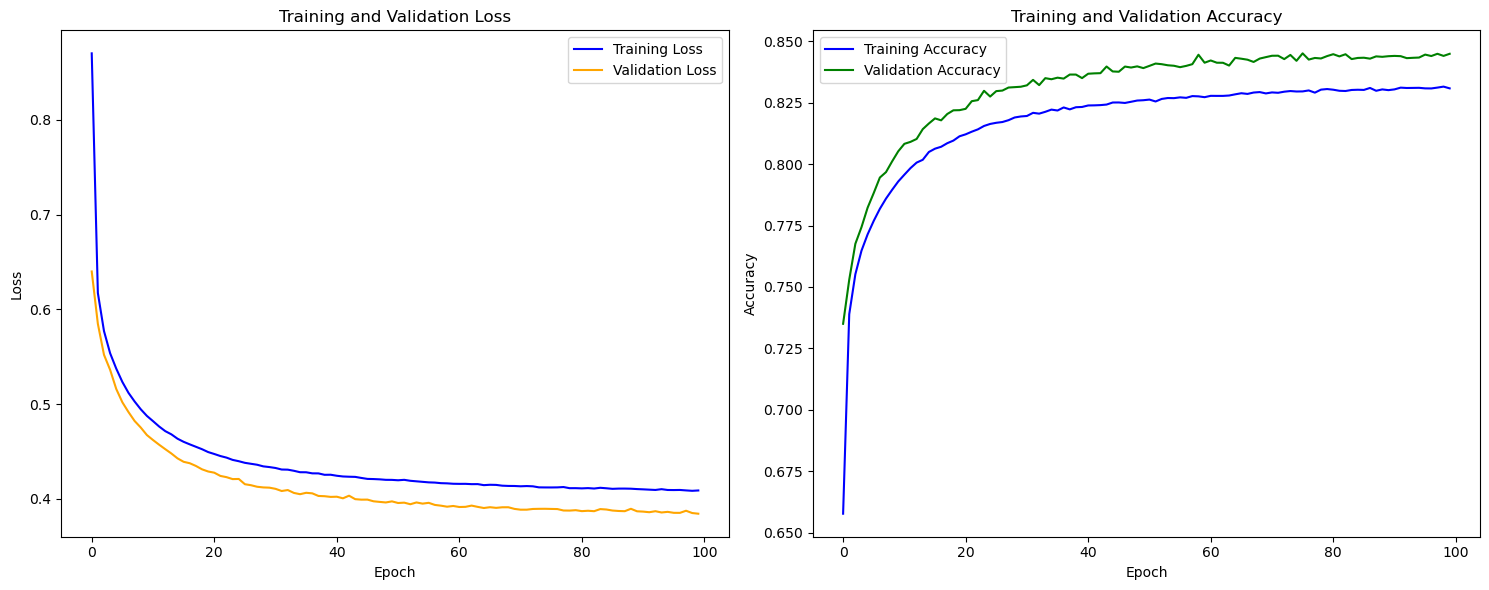

In [6]:

# 检查目标值类型并转换为 numpy 数组
if isinstance(y, pd.Series):
    y = y.to_numpy()
elif isinstance(y, pd.DataFrame):
    y = y.values.squeeze()  # 将 DataFrame 转换为 numpy，并确保是一维

# 检查目标值范围
print(f"原始目标值范围: min={y.min()}, max={y.max()}")

# 确保目标值从 0 开始
if np.min(y) == 1:  # 检查最小值是否为 1
    y = y - 1  # 确保目标值从 0 开始
elif np.min(y) < 0:  # 检查是否存在负值
    raise ValueError("目标值包含负值，请检查数据预处理步骤！")

# 再次检查目标值范围
print(f"调整后目标值范围: min={y.min()}, max={y.max()}")


# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 打印标准化后的数据
print("\n标准化后的数据（前5行）：")
print(X[:5])

# 数据集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换为 PyTorch 的 tensor 格式，并创建 DataLoader
batch_size = 2560

# 确保 y_train 和 y_test 是一维数组
y_train = y_train.to_numpy().ravel() if isinstance(y_train, pd.DataFrame) else y_train
y_test = y_test.to_numpy().ravel() if isinstance(y_test, pd.DataFrame) else y_test

# 转换为 PyTorch 的 tensor 格式
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 定义神经网络
class ForestCoverANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate, num_classes):
        super(ForestCoverANN, self).__init__()
        self.layers = nn.ModuleList()

        # 构建网络层
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))  # 第一个隐藏层的 Dropout

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))  # 中间层的 Dropout

        self.layers.append(nn.Linear(hidden_layers[-1], num_classes))  # 输出层

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 定义超参数
input_size = X_train_tensor.shape[1]
hidden_layers = [128, 64]  # 隐藏层神经元数量
dropout_rate = 0.05  # Dropout 的丢弃率
learning_rate = 0.001  # 学习率
alpha = 0.001  # L2 正则化
num_classes = len(np.unique(y))  # 分类数量
num_epochs = 100  # 最大迭代次数
early_stop_patience = 20  # 早停的容忍次数

# 模型实例化
model = ForestCoverANN(input_size, hidden_layers, dropout_rate, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)

# 记录训练和验证的损失与准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 训练循环
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    # 逐批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # 累加损失和正确预测数
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()

    # 计算平均训练损失和准确率
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stop triggered! Stopping training at epoch {epoch+1}.")
            break

# 可视化训练和验证过程
plt.figure(figsize=(15, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
